# GeoAI Challege Location Mention Recognition(LMR) from Social Media

### Data exploration and preparation

Challenge Link: https://zindi.africa/competitions/geoai-challege-location-mention-recognition-from-social-media

In [4]:
## Importing all required packages
import os
import re
import string
import pandas as pd
import numpy as np
import random
import operator
import matplotlib.pyplot as plt
import keras
from tabulate import tabulate
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras import layers, optimizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from plot_keras_history import plot_history
from tensorflow_addons.text.crf_wrapper import CRFModelWrapper
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\nabar\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
tf.random.set_seed(123)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '0'
random.seed(1254)

### Read processed data

In [6]:
current_directory = os.getcwd()
print(current_directory)

C:\Users\nabar\Documents\Data_Science\Challenge\Zindi\GeoAI Challege Location Mention Recognition from Social Media by ITU\Submission


In [7]:
data_df = pd.read_csv("train.csv", encoding="iso-8859-1", header=0)
val_df = pd.read_csv("val.csv", encoding="iso-8859-1", header=0)
test_df = pd.read_csv("test.csv", encoding="iso-8859-1", header=0)
data_df.head(12)

,Event_Name,Sentence,Word,POS,start_offset,Tag
0,california_wildfires_2018,1061497252806414336,Please,INTJ,0,O
1,california_wildfires_2018,1061497252806414336,read,VERB,7,O
2,california_wildfires_2018,1061497252806414336,below,ADP,12,O
3,california_wildfires_2018,1061497252806414336,!,PUNCT,17,O
4,california_wildfires_2018,1061497252806414336,!,PUNCT,18,O
5,california_wildfires_2018,1061497252806414336,Another,DET,20,O
6,california_wildfires_2018,1061497252806414336,devastating,ADJ,28,O
7,california_wildfires_2018,1061497252806414336,fire,NOUN,40,O
8,california_wildfires_2018,1061497252806414336,has,AUX,45,O
9,california_wildfires_2018,1061497252806414336,hit,VERB,49,O


In [8]:
print("Total number of tweet/sentences in the dataset: {:,}".format(data_df["Sentence"].nunique()))
print("Total words in the dataset: {:,}".format(data_df.shape[0]))

Total number of tweet/sentences in the dataset: 10,364
Total words in the dataset: 274,829


<Axes: >

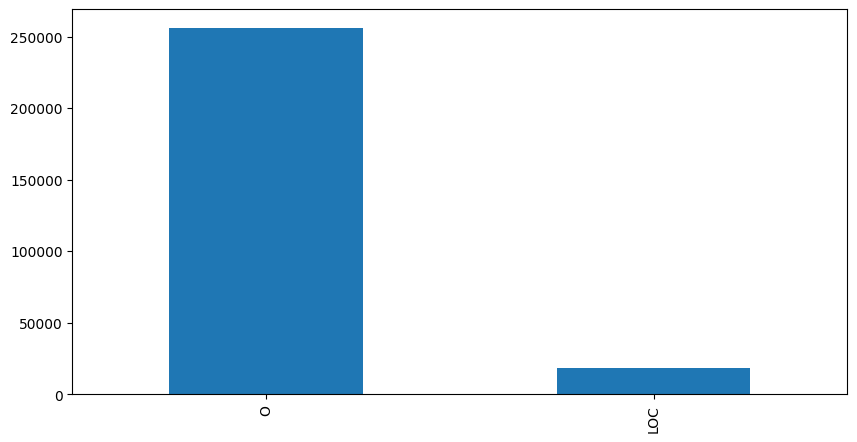

In [9]:
data_df["Tag"].value_counts().plot(kind="bar", figsize=(10,5))

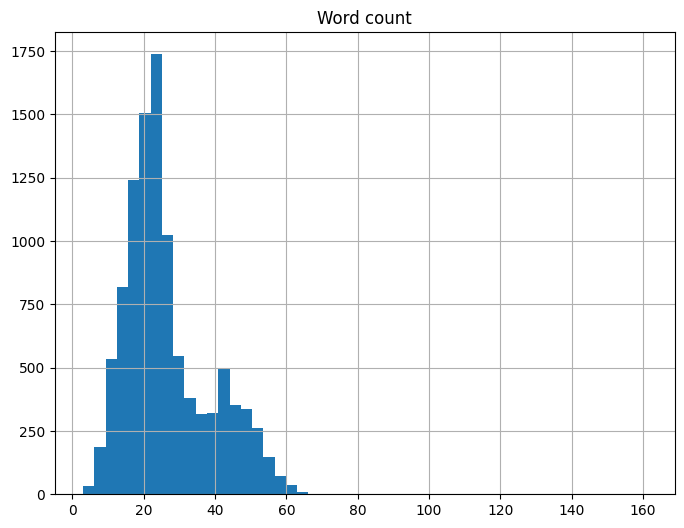

In [10]:
word_counts = data_df.groupby("Sentence")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

We see that the average sentence in the dataset contains about 21-22 words.

<Axes: >

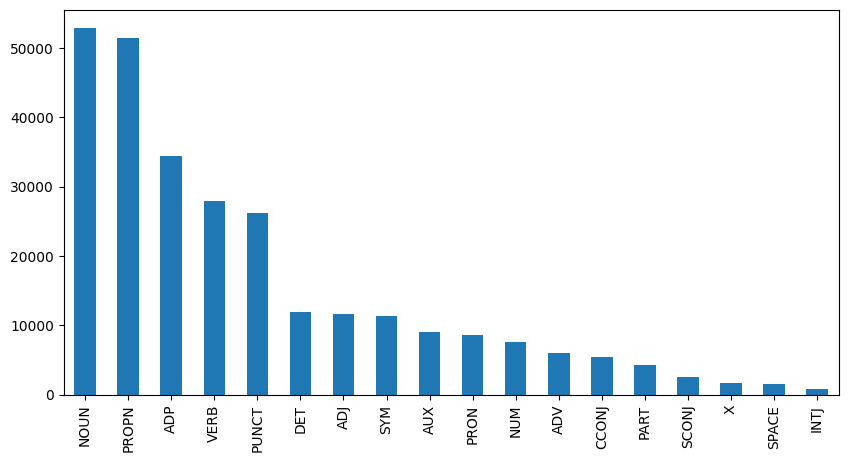

In [11]:
data_df["POS"].value_counts().plot(kind="bar", figsize=(10,5))

the tokens are mostly Noun

In [12]:
print("Most Common Tokens for Each Tag:")
tags = data_df['Tag'].unique()

for tag in tags:
    print(f"\nFor {tag}:")
    common_tokens = data_df[data_df['Tag'] == tag]['Word'].value_counts().nlargest(10)
    common_tokens_df = pd.DataFrame(common_tokens).reset_index()
    common_tokens_df.columns = ['Word', 'Frequency']
    print(tabulate(common_tokens_df, showindex=False, headers=common_tokens_df.columns, tablefmt='grid'))

Most Common Tokens for Each Tag:

For O:
+--------+-------------+
| Word   |   Frequency |
+========+=============+
| #      |       13052 |
+--------+-------------+
| .      |        8714 |
+--------+-------------+
| to     |        6818 |
+--------+-------------+
| ,      |        6307 |
+--------+-------------+
| @      |        6250 |
+--------+-------------+
| in     |        6190 |
+--------+-------------+
| the    |        6092 |
+--------+-------------+
| :      |        4968 |
+--------+-------------+
| of     |        4391 |
+--------+-------------+
| and    |        3599 |
+--------+-------------+

For LOC:
+------------+-------------+
| Word       |   Frequency |
+============+=============+
| Mexico     |         776 |
+------------+-------------+
| Nebraska   |         719 |
+------------+-------------+
| California |         653 |
+------------+-------------+
| Ecuador    |         587 |
+------------+-------------+
| Kerala     |         553 |
+------------+------------

In [13]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 161 words.


In [14]:
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))

ID of the longest sentence is 1033072591953514498.


In [15]:
longest_sentence = data_df[data_df["Sentence"]==longest_sentence_id]["Word"].str.cat(sep=' ')
print("The longest sentence in the corpus is:\n")
print(longest_sentence)

The longest sentence in the corpus is:

@ RaghupathiBhat @ Meenu_71 @ HarishK04131926 @ BJP4Udupi @ mattarhegde @ UdayKumarBJP @ YashpalBJP @ DheerajGbc @ GogoiRanju @ ajaykumar2697 @ Harvansh_Batra @ VictoryForNamo @ AmitShahKiSena @ imShefalii @ iSanjuktaP @ prayag @ BillionIndian @ LillyMaryPinto @ narendramodi @ sukanyaiyer2 @ shitijsrivastav @ Babble524 @ draksbond @ DrSarojiniMLC @ NazlinShaikh @ PathanAsmakhan @ kapil9994 @ pooja303singh @ AmitShah @ bakoriya_kirti _ @ narendrap85 @ YadavAnkes @ sbhandari16 @ DebashishHiTs @ BengaluruBullet @ meenakshisharan @ shakthigj @ shefalitiwari7 @ truevirathindu @ Dubey1Vij @ rajasve @ sanghavideepa @ BetiBachaoBetiP @ MinistryWCD @ dr_maheshsharma @ moefcc @ drharshvardhan @ nitin_gadkari @ raosahebdanve # NH66 Near Pangala ( b / w # Udupi # Mangaluru ) # flood water has began to flow over the # HighWay . MLA @ lalajibjp ji visited just now . Rescue Teams hav arrived . Water level is raising minute by minute . Same situation near # Padu

In [16]:
MAX_SENTENCE = 90 # based on distribution analysis

In [17]:
all_words = set(data_df["Word"].values)
all_tags = list(set(data_df["Tag"].values))
all_words_val = set(val_df["Word"].values)
all_words = all_words.union(all_words_val)
all_words = list(all_words)
print("Number of unique words: {}".format(len(all_words)))
print("Number of unique tags : {}".format(data_df["Tag"].nunique()))

Number of unique words: 28829
Number of unique tags : 2


Now that we are slightly more familiar with the data, we can proceed with implementing the necessary feature engineering. The first step is to build a dictionary (word2index) that assigns a unique integer value to every word from the corpus. We also construct a reversed dictionary that maps indices to words (index2word).

In [18]:
word2index = {word: idx + 2 for idx, word in enumerate(all_words)}

word2index["--UNKNOWN_WORD--"]=0

word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}

Let's look at the first 10 entries in the dictionary. Note that we have included 2 extra entries at the start - one for unknown words and one for padding.

In [19]:
for k,v in sorted(word2index.items(), key=operator.itemgetter(1))[:10]:
    print(k,v)

--UNKNOWN_WORD-- 0
--PADDING-- 1
9/17 2
benefiting 3
Thessaloniki 4
Destruction 5
plate 6
triggers 7
crippled 8
LeClere 9


Let's confirm that the word-to-index and index-to-word mapping works as expected.

In [20]:
test_word = "Mexico"

test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word Mexico is 5566.
The word with index 5566 is Mexico.


In [21]:
all_tags

['O', 'LOC']

Let's now build a similar dictionary for the various tags.

In [22]:
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

Next, we write a custom function that will iterate over each sentence, and form a tuple consisting of each token, the part of speech the token represents, and its tag. We apply this function to the entire dataset and then see what the transformed version of the first sentence in the corpus looks like.

In [23]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist(),
                   data["Sentence"].values.tolist(),
                   data["start_offset"].values.tolist())
    return [(word, pos, tag, tweet_id, start_offset) for word, pos, tag, tweet_id, start_offset in iterator]

sentences = data_df.groupby("Sentence").apply(to_tuples).tolist()
sentence_val = val_df.groupby("Sentence").apply(to_tuples).tolist()

print(sentences[0])

tweet_id_train = [sentence[0][3] for sentence in sentences]
start_offset_train = [[word[4] for word in sentence][:MAX_SENTENCE] for sentence in sentences]

[('RT', 'PROPN', 'O', 721565484492197888, 0), ('@', 'ADP', 'O', 721565484492197888, 3), ('MailOnline', 'PROPN', 'O', 721565484492197888, 4), (':', 'PUNCT', 'O', 721565484492197888, 14), ('At', 'ADP', 'O', 721565484492197888, 16), ('least', 'ADJ', 'O', 721565484492197888, 19), ('41', 'NUM', 'O', 721565484492197888, 25), ('people', 'NOUN', 'O', 721565484492197888, 28), ('killed', 'VERB', 'O', 721565484492197888, 35), ('in', 'ADP', 'O', 721565484492197888, 42), ('Ecuador', 'PROPN', 'LOC', 721565484492197888, 45), ('earthquake', 'NOUN', 'O', 721565484492197888, 53), (',', 'PUNCT', 'O', 721565484492197888, 63), ('sparking', 'VERB', 'O', 721565484492197888, 65), ('tsunami', 'PROPN', 'O', 721565484492197888, 74), ('warning', 'VERB', 'O', 721565484492197888, 82)]


We use this transformed dataset to extract the features (X) and labels (y) for the model. We can see what the first entries in X and y look like, after the two have been populated with words and tags. We can discard the part of speech data, as it is not needed for this specific implementation.

In [24]:
X = [[word[0] for word in sentence] for sentence in sentences]

y = [[word[2] for word in sentence] for sentence in sentences]
X_val = [[word[0] for word in sentence] for sentence in sentence_val]
y_val = [[word[2] for word in sentence] for sentence in sentence_val]

print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['RT', '@', 'MailOnline', ':', 'At', 'least', '41', 'people', 'killed', 'in', 'Ecuador', 'earthquake', ',', 'sparking', 'tsunami', 'warning']
y[0]: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O']


In [25]:
MAX_SENTENCE

90

We also need to replace each word with its corresponding index from the dictionary.

In [26]:
X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
X_val = [[word2index[word] for word in sentence] for sentence in X_val]
y_val = [[tag2index[tag] for tag in sentence] for sentence in y_val]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [25713, 12966, 23215, 2506, 5396, 9040, 17649, 14992, 28518, 14704, 20716, 16882, 2349, 9403, 24504, 6777]
y[0]: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]


We see that the dataset has now been indexed. We also need to pad each sentence to the maximal sentence length in the corpus, as the LSTM model expects a fixed length input. This is where the extra "--PADDING--" key in the dictionary comes into play.

In [27]:
X_train = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
X_train = [sentence[:MAX_SENTENCE] for sentence in X_train]
y_train = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
y_train = [sentence[:MAX_SENTENCE] for sentence in y_train]
X_val = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X_val]
X_val = [sentence[:MAX_SENTENCE] for sentence in X_val]
y_val = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y_val]
y_val = [sentence[:MAX_SENTENCE] for sentence in y_val]
print("X_train[0]:", X_train[0])
print("y_train[0]:", y_train[0])

X_train[0]: [25713, 12966, 23215, 2506, 5396, 9040, 17649, 14992, 28518, 14704, 20716, 16882, 2349, 9403, 24504, 6777, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y_train[0]: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
type(X_train[0][-1])

int

In [29]:
tag2index

{'O': 1, 'LOC': 2, '--PADDING--': 0}

In [26]:
TAG_COUNT = len(tag2index)

In [27]:
#We can also convert everything into NumPy arrays, as this makes feeding the data to the model simpler.
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [28]:
X_train

array([[ 4765, 13016, 10990, ...,     1,     1,     1],
       [ 4765, 13016, 11006, ...,     1,     1,     1],
       [ 4765, 13016, 16252, ...,     1,     1,     1],
       ...,
       [ 1109,   459,  6443, ...,     1,     1,     1],
       [ 7039,  9647, 22360, ...,     1,     1,     1],
       [ 2607, 22041, 24437, ...,     1,     1,     1]])

In [29]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((10364, 90), (1483, 90), (10364, 90), (1483, 90))

In [30]:
print("Data type of X_train:", X_train.dtype)
print("Data type of X_test:", X_val.dtype)
print("Data type of y_train:", y_train.dtype)
print("Data type of y_test:", y_val.dtype)

Data type of X_train: int32
Data type of X_test: int32
Data type of y_train: int32
Data type of y_test: int32


In [31]:
# Download and load the GloVe embeddings
glove_file = current_directory + r"\glove\glove.twitter.27B.100d.txt"
glove_embeddings = {}
with open(glove_file, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = embedding

In [32]:
# Create an embedding matrix
embedding_dim = 100  # Change this to the dimension of your GloVe embeddings if different
embedding_matrix = np.zeros((len(word2index), embedding_dim))

for word, idx in word2index.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]

# Modelling

We start by calculating the maximal word length. We also set the following model hyperparameters:

* DENSE_EMBEDDING - Dimension of the dense embedding
* LSTM_UNITS - Dimensionality of the LSTM output space
* LSTM_DROPOUT - Fraction of the LSTM units to drop for the linear transformation of the recurrent state
* DENSE_UNITS - Number of fully connected units for each temporal slice
* BATCH_SIZE - Number of samples in a training batch
* MAX_EPOCHS - Maximum number of training epochs

In [33]:
WORD_COUNT = len(index2word)
DENSE_EMBEDDING = 100
LSTM_UNITS = 64
LSTM_DROPOUT = 0.15
DENSE_UNITS = 64

We proceed by defining the architecture of the model. We add an input layer, an embedding layer (to transform the indexes into dense vectors, a bidirectional LSTM layer. We then pipe this to a CRF layer, and finally construct the model by defining its input as the input layer and its output as the output of the CRF layer.

The optimiser is set to Adam (Kingma and Ba, 2015) with a learning rate of 0.02.

In [34]:
def build_embedding_bilstm_model(
    vocab_size: int, embed_dims: int, lstm_unit: int, max_sen_len: int
) -> tf.keras.Model:
    x = tf.keras.layers.Input(shape=(max_sen_len,), dtype=tf.int32, name="Input")
    y = tf.keras.layers.Embedding(vocab_size, embed_dims, input_length=max_sen_len, weights=[embedding_matrix], trainable=True)(x)#
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_unit, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(y)
    #y = tf.keras.layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(y)
    return tf.keras.Model(
        inputs=x, outputs=y
    )


base_model = build_embedding_bilstm_model(WORD_COUNT, DENSE_EMBEDDING, LSTM_UNITS, MAX_SENTENCE)


In [35]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 90)]              0         
                                                                 
 embedding (Embedding)       (None, 90, 100)           2883100   
                                                                 
 bidirectional (Bidirection  (None, 90, 128)           84480     
 al)                                                             
                                                                 
Total params: 2967580 (11.32 MB)
Trainable params: 2967580 (11.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Wrapper base model with CRF model wrapper
The CRF model wrapper wraps the base model. It will apply the CRF layer to the output of the base model and compute the CRF loss. The wrapper takes the base model and number of tags (for initializing the CRF layer) as the initialization parameters.

In [36]:
ner_model = CRFModelWrapper(base_model, TAG_COUNT)

#### Training model
The compilation of the wrappered model is exactly the same as that of the regular Keras model, except that there is no need to provide a loss function (the wrappered model computes the CRF loss internally).

In [37]:
ner_model.compile(optimizer=tf.keras.optimizers.Adam(0.02))

In [38]:
BATCH_SIZE = 128 #128
MAX_EPOCHS = 3

In [39]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_data=(X_val, y_val), verbose=1)

Epoch 1/3
81/81 [==============================] - 70s 693ms/step - loss: 4.3553 - crf_loss: 4.3553 - val_loss: 1.2211 - val_crf_loss: 1.2211
Epoch 2/3
81/81 [==============================] - 57s 703ms/step - loss: 0.6951 - crf_loss: 0.6951 - val_loss: 1.2481 - val_crf_loss: 1.2481
Epoch 3/3
81/81 [==============================] - 57s 709ms/step - loss: 0.4991 - crf_loss: 0.4991 - val_loss: 1.3325 - val_crf_loss: 1.3325


In [40]:
#history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_data=(X_val, y_val), verbose=1)

#### Evaluation and testing
We can inspect the loss and accuracy plots from the model training. They both look acceptable and it doesn't appear that the model is overfitting. The model training could definitely benefit from some hyperparameter optimisation, but this type of fine-tuning is out of scope for this post.

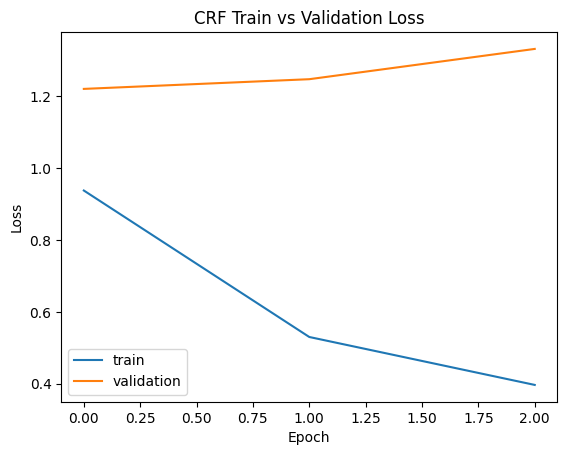

In [41]:
# Plotting Training vs Validation Accuracy
plt.plot(history.history['crf_loss'])  
plt.plot(history.history['val_crf_loss'])  
plt.title('CRF Train vs Validation Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')
plt.legend(['train', 'validation']) 
plt.show()

#### Making inference
Inspect the predicted result:

In [42]:
y_pred = ner_model.predict(X_val)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_val, axis=1)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}".format(accuracy))

47/47 [==============================] - 3s 41ms/step
Accuracy: 0.8483


It appears that the model is doing quite well, however this is slightly misleading. This is a highly imbalanced dataset because of the very high number of O-tags that are present in the training and test data. There is further imbalance between the samples including the various tag classes. A better inspection would be to construct confusion matrices for each tag and judge the model performance based on those. We can construct a simple Python function to assist with inspection of the confusion matrices for individual tags. We use two randomly selected tags to give us a sense of what the confusion matrices for individual tags would look like.

In [43]:
from sklearn.metrics import multilabel_confusion_matrix
def tag_conf_matrix(cm, tagid):
    tag_name = index2tag[tagid]
    print("Tag name: {}".format(tag_name))
    print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    print("Tag accuracy: {:.3f} \n".format(tag_acc))

matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())

tag_conf_matrix(matrix, 0)
tag_conf_matrix(matrix, 1)
tag_conf_matrix(matrix, 2)

Tag name: --PADDING--
[[1259  105]
 [   7  112]]
Tag accuracy: 0.924 

Tag name: O
[[1420    4]
 [  11   48]]
Tag accuracy: 0.990 

Tag name: LOC
[[1437    3]
 [   4   39]]
Tag accuracy: 0.995 



# Sample test

In [44]:
for i in range(len(tweet_id_train)):
    if str(tweet_id_train[i]) == '1031191070229450753':#721565577505030144 , 1031191070229450753
        print(i)
        k = i
        Xtt = [[word[0] for word in sentence] for sentence in sentences]
        print(Xtt[k])
        sentence = Xtt[k]
        Xtt = [[word2index[word] for word in sentence] for sentence in Xtt]
        Xtt1 = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in Xtt]
        Xtt1 = [sentence[:MAX_SENTENCE] for sentence in Xtt1]
        xtt1_train = np.array([Xtt1[k]])
        print(Xtt[k])
        print(Xtt1[k])
        pred = ner_model.predict(np.array(xtt1_train), verbose = 0)
        
        break

6335
['#', 'KeralaFloodRelief', '#', 'KeralaFloods2018', 'anyone', 'know', 'reliable', 'water', 'tanker', 'suppliers', 'in', 'Coimbatore', 'please', 'reply', '.', 'Need', 'drinking', 'water', 'supplies', 'to', 'be', 'sent', 'to', 'Ernakulam', ',', 'Aluva', '.']
[16373, 15321, 16373, 26537, 17060, 7926, 3233, 9168, 20525, 13120, 7065, 19538, 21161, 23582, 10354, 24084, 10877, 9168, 9759, 28161, 23937, 26686, 28161, 7079, 3922, 15241, 10354]
[16373, 15321, 16373, 26537, 17060, 7926, 3233, 9168, 20525, 13120, 7065, 19538, 21161, 23582, 10354, 24084, 10877, 9168, 9759, 28161, 23937, 26686, 28161, 7079, 3922, 15241, 10354, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [45]:
pred

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [46]:
results = []
retval = ""
loc_count = 0
flag = 0
loc_start = None # Initialize start index for 'LOC' tag sequence
loc_end = None # Initialize end index for 'LOC' tag sequence
start_offset = None # Initialize character-based start index for 'LOC' tag sequenc
for j, (w, p, q) in enumerate(zip(sentence, pred[0], start_offset_train[k])):
    print(w,index2tag[p], q)
    tag = index2tag[p]
    if tag == 'LOC':
        if start_offset is None:
            start_offset = q
        end_offset = q + len(w)
    else:
        if start_offset is not None:
            loc_count = loc_count + 1
            results.append((w, loc_count, start_offset, end_offset))
            flag = 0
            start_offset = None
# If the sentence ends with a 'LOC' tag sequence, record it
if start_offset is not None:# last occurrence
    loc_count = loc_count +1
    results.append((w, loc_count, start_offset, end_offset))
print(retval)
print(results)

# O 0
KeralaFloodRelief O 1
# O 19
KeralaFloods2018 O 20
anyone O 37
know O 44
reliable O 49
water O 58
tanker O 64
suppliers O 71
in O 81
Coimbatore LOC 84
please O 95
reply O 102
. O 107
Need O 109
drinking O 114
water O 123
supplies O 129
to O 138
be O 141
sent O 144
to O 149
Ernakulam LOC 152
, O 161
Aluva LOC 163
. O 168

[('please', 1, 84, 94), (',', 2, 152, 161), ('.', 3, 163, 168)]


# Submission

Now inference time.

In [47]:
def to_tuples_test(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["Sentence"].values.tolist(),
                   data["start_offset"].values.tolist())
    return [(word, pos, start_offset) for word, pos,start_offset in iterator]
sentence_test = test_df.groupby("Sentence").apply(to_tuples_test).tolist()

In [48]:
tweet_id_test = [sentence[0][1] for sentence in sentence_test]
start_offset_test = [[word[2] for word in sentence][:MAX_SENTENCE] for sentence in sentence_test]

print(sentence_test[0])
print(tweet_id_test[0])

[('RT', 721565577505030144, 0), ('@', 721565577505030144, 3), ('YourAnonCentral', 721565577505030144, 4), (':', 721565577505030144, 19), ('Since', 721565577505030144, 21), ('#', 721565577505030144, 27), ('Ecuador', 721565577505030144, 28), ('earthquake', 721565577505030144, 36), ('struck', 721565577505030144, 47), ('at', 721565577505030144, 54), ('night', 721565577505030144, 57), (',', 721565577505030144, 62), ('authorities', 721565577505030144, 64), ('warn', 721565577505030144, 76), (',', 721565577505030144, 80), ('number', 721565577505030144, 82), ('of', 721565577505030144, 89), ('confirmed', 721565577505030144, 92), ('deaths', 721565577505030144, 102), ('likely', 721565577505030144, 109), ('higher', 721565577505030144, 116), ('by', 721565577505030144, 123), ('morning', 721565577505030144, 126), ('.', 721565577505030144, 133), ('htt', 721565577505030144, 135)]
721565577505030144


In [49]:
tweet_id_test[0]

721565577505030144

now lets do the same feature engineering for test data the same way we did for train data.

In [50]:
Xtt = [[word[0] for word in sentence] for sentence in sentence_test]
Xtt1 = [[word2index.get(word, 0) for word in sentence] for sentence in Xtt]
Xtt2 = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in Xtt1]
Xtt2 = [sentence[:MAX_SENTENCE] for sentence in Xtt2]
xtt_train2 = np.array(Xtt2)


Now for each test sentence we do the prediction and at the same time we store the required details like tweet id, start offset, end offset.

In [51]:
results = []
for i in range(len(Xtt2)):
    print(i)
    pred = ner_model.predict(np.array([Xtt2[i]]), verbose = 0)
    loc_count = 0
    flag = 0
    loc_start = None # Initialize start index for 'LOC' tag sequence
    loc_end = None # Initialize end index for 'LOC' tag sequence
    start_offset = None # Initialize character-based start index for 'LOC' tag sequenc
    for j, (w, p, q) in enumerate(zip(Xtt,pred[0], start_offset_test[i])):
        #print(index2tag[p], q)
        tag = index2tag[p]
        if tag == 'LOC':
            if start_offset is None:
                start_offset = q
            end_offset = q + len(w)
        else:
            if start_offset is not None:
                loc_count = loc_count + 1
                results.append((tweet_id_test[i], loc_count, start_offset, end_offset))
                flag = 0
                start_offset = None
    # If the sentence ends with a 'LOC' tag sequence, record it
    if start_offset is not None:# last occurrence
        loc_count = loc_count +1
        results.append((tweet_id_test[i], loc_count, start_offset, end_offset))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

creating a final dataframe from the set of results.

In [52]:
output_df = []
# Print the results in the desired format
for item in results:
    #print(item)
    tweet_id = item[0]
    loc_count = item[1]
    char_start = item[2]
    char_end = item[3]
    output_df.append([f"ID_{tweet_id}_loc{loc_count}_start", char_start])
    output_df.append([f"ID_{tweet_id}_loc{loc_count}_end", char_end])

In [53]:
submission_file = pd.DataFrame(output_df, columns = ['Tweet_ID', 'Index'])

Now time to merge this with sample submission file. we will do the left join here.

In [54]:
sample_submission = pd.read_csv('SampleSubmission.csv')
sample_submission.drop(['Index'], axis = 1, inplace = True)

In [55]:
final_submission = pd.merge(sample_submission, submission_file, how = 'left', on = ['Tweet_ID'])

In [56]:
final_submission.fillna(0, inplace = True)

In [57]:
final_submission['Index'] = final_submission['Index'].astype(int)

In [58]:
final_submission.to_csv('final_submission.csv', index = False)

In [59]:
# End